In [45]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2023, 10)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.*, stocks.stock_name as name from month_chart
    join stocks on month_chart.code = stocks.stock_code
    where year(date) >= {begin.year}
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지
    df1 = df1[df1["val_last"] > 1_0000_0000]  # 거래량 1억 이상(거래량 적을 시 매수 실패할거라고 가정)

    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0) | (df2["val_last"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "시가총액": df1["cap"],
        "거래량": df1["vol"],
        "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "val": df1["val"],
        "val_last": df1["val_last"],
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    fn_sep = fs_loader.load(settled_qtr.year, settled_qtr.qtr, 0)
    fn_sep.columns = ["sep_" + col for col in fn_sep.columns]
    layer1 = pd.concat([layer1, df.join(fn).join(fn_sep)])

layer1.reset_index(inplace=True)
layer1.to_csv(".analysis/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

layer1 = pd.read_csv(".analysis/layer1.csv", dtype={"code": str})
layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1 = layer1[layer1["확정실적"].notna()]
layer1

,code,매수년월,매도년월,종목명,매수일,매수가,시가총액,거래량,거래대금,전월수익률,...,sep_R/A_QoQ,sep_R/EQ_QoQ,sep_GP/A_QoQ,sep_GP/EQ_QoQ,sep_O/A_QoQ,sep_O/EQ_QoQ,sep_EBT/A_QoQ,sep_EBT/EQ_QoQ,sep_E/A_QoQ,sep_E/EQ_QoQ
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,064260,2014-04,2014-05,다날,2014-04-30,10100.0,2.063363e+11,19577010.0,2.160986e+11,-0.133047,...,0.006118,0.012601,0.006118,0.012601,-0.000585,-0.000973,0.031489,0.058377,0.029841,0.055276
65,001810,2014-04,2014-05,무림SP,2014-04-30,3135.0,6.940106e+10,6101825.0,1.867097e+10,0.144161,...,-0.007497,-0.018161,-0.006286,-0.010604,0.008386,0.012673,-0.010245,-0.016243,-0.008999,-0.014192
66,060560,2014-04,2014-05,홈센타홀딩스,2014-04-30,2615.0,7.097781e+10,4889251.0,1.354574e+10,-0.069395,...,-0.021532,-0.030904,0.004396,0.006290,-0.004200,-0.006018,-0.005678,-0.008135,-0.001654,-0.002371
67,105840,2014-04,2014-05,우진,2014-04-30,8050.0,1.397480e+11,445266.0,3.631067e+09,-0.020681,...,-0.008822,-0.004427,0.019127,0.024698,0.015531,0.019424,0.015571,0.019600,0.009883,0.012650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200911,096610,2023-09,2023-10,알에프세미,2023-09-27,9270.0,1.466157e+11,6830717.0,8.108752e+10,-0.421709,...,-0.043295,-0.204366,-0.022579,-0.039592,-0.010866,0.015177,-0.029397,-0.018766,-0.006243,0.028617
200912,085660,2023-09,2023-10,차바이오텍,2023-09-27,18330.0,1.032244e+12,27531699.0,5.674048e+11,0.040295,...,0.008956,0.016349,0.004635,0.008364,0.001720,0.002528,0.074909,0.111599,0.078266,0.116888
200913,042670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,0.006945,-0.180091,0.017134,0.006302,0.017692,0.028277,0.014757,0.020343,0.010612,0.013974
200914,054620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,0.001601,0.002333,0.000167,0.000237,-0.003945,-0.005778,0.018090,0.026494,0.013505,0.019778


In [104]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P"
    }
)

factors = [col for col in layer1.columns if col.endswith("QoQ")]
factors += ["P"]

# 가격비율
layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
factors.append("EQ/P")

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    factor = f"{col}/P"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["P"]
    factors.append(factor)

    # 자산비율
    factor = f"{col}/A"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["A"]
    factors.append(factor)

    # 자본비율
    factor = f"{col}/EQ"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["EQ"]
    factors.append(factor)

    # 이익율
    if col != "R":
        factor = f"{col}/R"
        layer2[factor] = layer2[f"{col}/Y"] / layer2["R/Y"]
        factors.append(factor)

# =============================================
# 별도 재무제표 팩터 계산
# factors += [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
# layer2["sep_EQ/P"] = layer2["sep_EQ"] / layer2["P"]
# factors.append("sep_EQ/P")
# for col in is_cols:
#     factor = f"sep_{col}/P"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["P"]
#     factors.append(factor)
# 
#     # 자산비율
#     factor = f"sep_{col}/A"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["sep_A"]
#     factors.append(factor)
# 
#     # 자본비율
#     factor = f"sep_{col}/EQ"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["sep_EQ"]
#     factors.append(factor)
# 
#     # 이익율
#     factor = f"sep_{col}/R"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["sep_R/Y"]
#     factors.append(factor)
# =============================================

recipes = {
    "벨류": {
        "GP/P": 0.1205,
        "EQ/P": 0.1056,
        # "R/P": 0.0779
    },
    "퀄리티": {
        "GP/A": 0.0328,
        "GP/EQ": 0.0284,
        "R/A": 0.0129,
        "GP/R": 0.0121,
        "O/A": 0.0098,
    },
    "성장": {
        "O_QoQ": 0.1276,
        "E_QoQ": 0.1241,
        "EBT_QoQ": 0.1142,
        "O/A_QoQ": 0.1138,
        "O/EQ_QoQ": 0.1085,
        "E/EQ_QoQ": 0.1017,
        "EBT/EQ_QoQ": 0.0976,
        "E/A_QoQ": 0.0972,
        "GP/A_QoQ": 0.0966,
        "EBT/A_QoQ": 0.0959,
        "GP/EQ_QoQ": 0.0796,
        "GP_QoQ": 0.0748,
        "R/A_QoQ": 0.0676,
        "R_QoQ": 0.0568,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
    }
}


result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    # 개별 팩터 백분위 계산
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(pct=True) * 100)

    # 별도 재무제표 팩터 백분위 반영
    # for factor in factors:
    #     if not factor.startswith("sep_") and f"sep_{factor}" in factors:
    #         df[f"{factor}_pct"] = np.ceil(df[[f"sep_{factor}_pct", f"{factor}_pct"]].mean(axis=1))

    # 혼합 팩터 계산
    for title, recipe in recipes.items():
        df[title] = sum([df[f"{k}_pct"] * w for k, w in recipe.items()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(pct=True) * 100)

    result = pd.concat([result, df])

result

2023-10

,code,매수년월,매도년월,종목명,매수일,매수가,P,거래량,거래대금,전월수익률,...,E/EQ_pct,E/R_pct,벨류,벨류_pct,퀄리티,퀄리티_pct,성장,성장_pct,전략,전략_pct
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,064260,2014-04,2014-05,다날,2014-04-30,10100.0,2.063363e+11,19577010.0,2.160986e+11,-0.133047,...,26.0,26.0,12.3992,56.0,7.3915,86.0,95.6477,75.0,65.0,60.0
65,001810,2014-04,2014-05,무림SP,2014-04-30,3135.0,6.940106e+10,6101825.0,1.867097e+10,0.144161,...,50.0,60.0,20.0037,93.0,3.3756,30.0,58.7691,44.0,109.0,86.0
66,060560,2014-04,2014-05,홈센타홀딩스,2014-04-30,2615.0,7.097781e+10,4889251.0,1.354574e+10,-0.069395,...,37.0,43.0,11.3996,50.0,2.0957,13.0,69.0505,52.0,73.0,65.0
67,105840,2014-04,2014-05,우진,2014-04-30,8050.0,1.397480e+11,445266.0,3.631067e+09,-0.020681,...,37.0,59.0,7.7807,29.0,2.5272,18.0,114.2059,92.0,67.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200911,096610,2023-09,2023-10,알에프세미,2023-09-27,9270.0,1.466157e+11,6830717.0,8.108752e+10,-0.421709,...,9.0,7.0,1.9306,6.0,0.4056,1.0,42.2541,25.0,-15.0,13.0
200912,085660,2023-09,2023-10,차바이오텍,2023-09-27,18330.0,1.032244e+12,27531699.0,5.674048e+11,0.040295,...,21.0,22.0,10.6254,47.0,5.0507,52.0,101.0795,80.0,39.0,40.0
200913,042670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,92.0,71.0,14.7995,68.0,7.5377,87.0,112.3573,89.0,63.0,59.0
200914,054620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,40.0,78.0,10.6455,47.0,1.8697,13.0,61.5631,44.0,42.0,42.0


[4/4] 전략티2014-04 2023-10


,slope,spearman,kendall,t10,h10,t10-h10,mean,median,strength
전략,0.363539,0.902010,0.728485,0.266563,-0.100820,0.367383,0.047467,0.042217,0.327916
벨류,0.191873,0.742226,0.560000,0.117430,-0.085599,0.203029,0.045101,0.049138,0.142413
성장,0.178200,0.742250,0.565253,0.145405,-0.013651,0.159056,0.046627,0.048104,0.132269
퀄리티,0.080777,0.403804,0.289697,0.038770,-0.046401,0.085171,0.045099,0.044536,0.032618


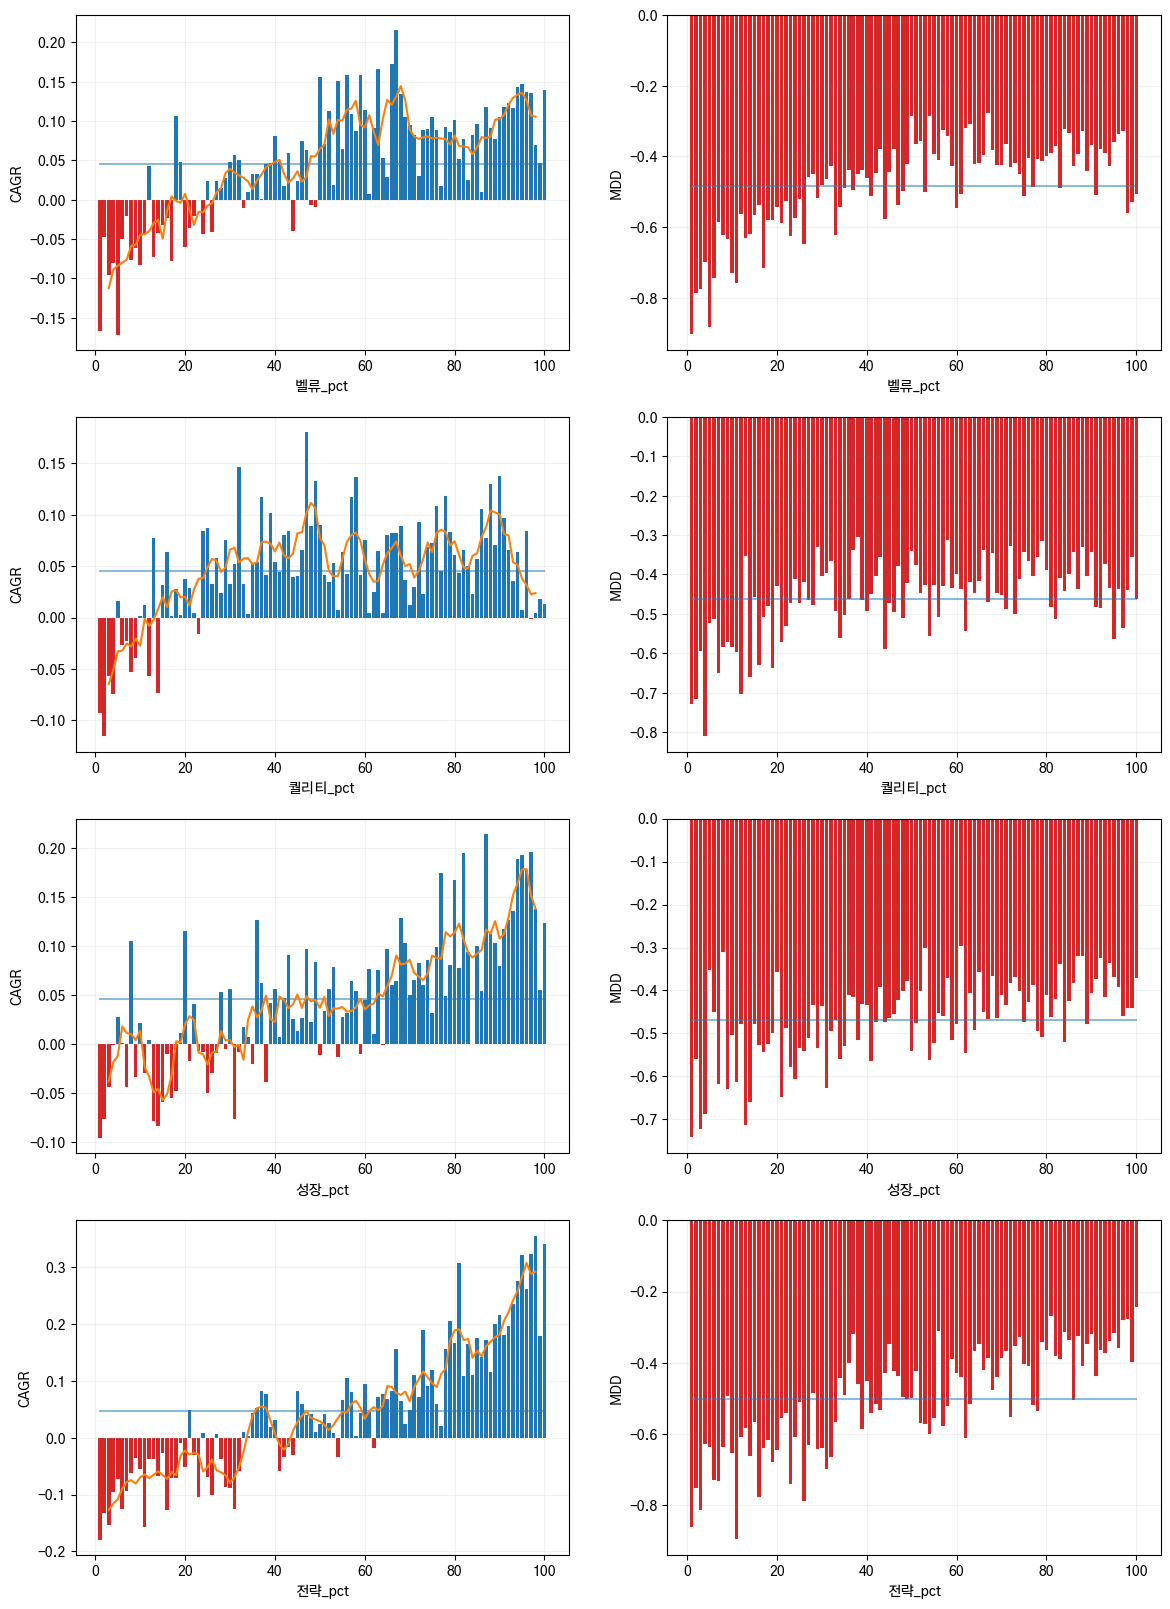

In [105]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr as calc_cagr
from utils.quantutil import mdd as calc_mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(14), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = result[colname].dropna().sort_values().unique()
    cagr, mdd = [], []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        cagr.append(calc_cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd.append(calc_mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    pcts = pd.Series(pcts)
    cagr, mdd = pd.Series(cagr), pd.Series(mdd)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr, color=["tab:blue" if v > 0 else "tab:red" for v in cagr])
    ax1.plot(pd.Series(pcts), [cagr.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd, color=["tab:blue" if v > 0 else "tab:red" for v in mdd])
    ax2.plot(pd.Series(pcts), [mdd.mean() for _ in pd.Series(pcts)], alpha=0.5)

    pct_mean = pcts.mean()
    cagr_mean = cagr.mean()

    try:
        slope = sum((pcts - pct_mean) * (cagr * 100 - cagr_mean)) / sum((pcts - pct_mean) ** 2)
    except:
        slope = -1

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr(method="kendall")
    summary = pd.concat([
        summary,
        pd.Series({
            "slope": slope,
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "t10": cagr.tail(10).mean(),
            "h10": cagr.head(10).mean(),
            "t10-h10": cagr.tail(10).mean() - cagr.head(10).mean(),
            "mean": cagr.mean(),
            "median": cagr.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["slope"]

print(result["매수년월"].min(), result["매도년월"].max())
summary = summary.sort_values(by="strength", ascending=False)
summary.to_csv(".analysis/summary.csv")
summary

In [106]:
# 백테스트

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

result2 = result.copy()[result[factor].notna()]

result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

port_size = 20
port = result2.groupby(_key).apply(lambda x: x.sort_values("전략", ascending=False).head(port_size))
strategy = port.reset_index(drop=True).groupby(_key)["수익률"].mean()
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "BM 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": strategy - benchmark,
    "BM 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod(),
})

running_max = revisions["BM 누적수익률"].cummax()
revisions["BM DD"] = (revisions["BM 누적수익률"] - running_max) / running_max

running_max = revisions["전략 누적수익률"].cummax()
revisions["전략 DD"] = (revisions["전략 누적수익률"] - running_max) / running_max

revisions = revisions.dropna()

years = len(revisions) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["BM 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["BM 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["BM 수익률"].mean()]
}, index=["전략", "BM"])
print(summary)

result3 = port.reset_index(drop=True).groupby(_key).apply(lambda x: x.sort_values("수익률", ascending=False))[[
    "code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "consolidated",
    "P_pct", "성장_pct", "벨류_pct", "퀄리티_pct", f"{factor}_pct"
]]
result3 = result3.reset_index(drop=True)
result3.to_csv(".analysis/port.csv")
result3

전략
        CAGR                                        MDD      Mean
전략  0.350308  (-0.2591107426745197, (2018-05, 2020-03))  0.028610
BM  0.048336  (-0.3674258518414856, (2018-05, 2020-03))  0.005877


,code,종목명,수익률,매수일,매도일,매수가,매도가,consolidated,P_pct,성장_pct,벨류_pct,퀄리티_pct,전략_pct
0,054940,엑사이엔씨,0.215470,2014-04-30,2014-05-30,905.0,1100.0,1.0,3.0,58.0,98.0,71.0,98.0
1,005750,대림비앤코,0.157746,2014-04-30,2014-05-30,3550.0,4110.0,1.0,20.0,82.0,92.0,17.0,98.0
2,024940,PN풍년,0.103774,2014-04-30,2014-05-30,2120.0,2340.0,0.0,3.0,91.0,92.0,88.0,100.0
3,003310,대주산업,0.029008,2014-04-30,2014-05-30,655.0,674.0,1.0,3.0,77.0,95.0,45.0,100.0
4,014200,광림,0.028571,2014-04-30,2014-05-30,1925.0,1980.0,0.0,10.0,96.0,86.0,35.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,002070,비비안,-0.064541,2023-09-27,2023-10-31,1317.0,1232.0,0.0,5.0,84.0,96.0,96.0,100.0
2276,308100,까스텔바작,-0.067594,2023-09-27,2023-10-31,5030.0,4690.0,1.0,3.0,74.0,87.0,67.0,99.0
2277,038950,파인디지털,-0.109615,2023-09-27,2023-10-31,5200.0,4630.0,1.0,10.0,87.0,83.0,71.0,100.0
2278,900260,로스웰,-0.126794,2023-09-27,2023-10-31,836.0,730.0,1.0,2.0,97.0,93.0,15.0,100.0


In [107]:
revisions.to_csv(".analysis/revisions.csv")
revisions

,,BM 수익률,전략 수익률,성능,BM 누적수익률,전략 누적수익률,BM DD,전략 DD
매수년월,매도년월,,,,,,,
2014-04,2014-05,-0.008505,-0.023286,-0.014781,0.991495,0.976714,0.000000,0.000000
2014-05,2014-06,-0.008698,0.007949,0.016647,0.982871,0.984477,-0.008698,0.000000
2014-06,2014-07,0.014296,0.045416,0.031120,0.996923,1.029189,0.000000,0.000000
2014-07,2014-08,0.040334,0.092140,0.051806,1.037132,1.124018,0.000000,0.000000
2014-08,2014-09,0.012084,0.076153,0.064069,1.049665,1.209616,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-05,2023-06,0.008392,0.011799,0.003407,1.865186,19.788003,-0.221545,-0.091255
2023-06,2023-07,-0.027836,-0.039733,-0.011896,1.813266,19.001772,-0.243214,-0.127362
2023-07,2023-08,0.016717,-0.011611,-0.028328,1.843579,18.781151,-0.230563,-0.137493


total            114.000000
out-perform       80.000000
under-perform     34.000000
승률                 0.701754
누적 성능             10.833555
dtype: float64

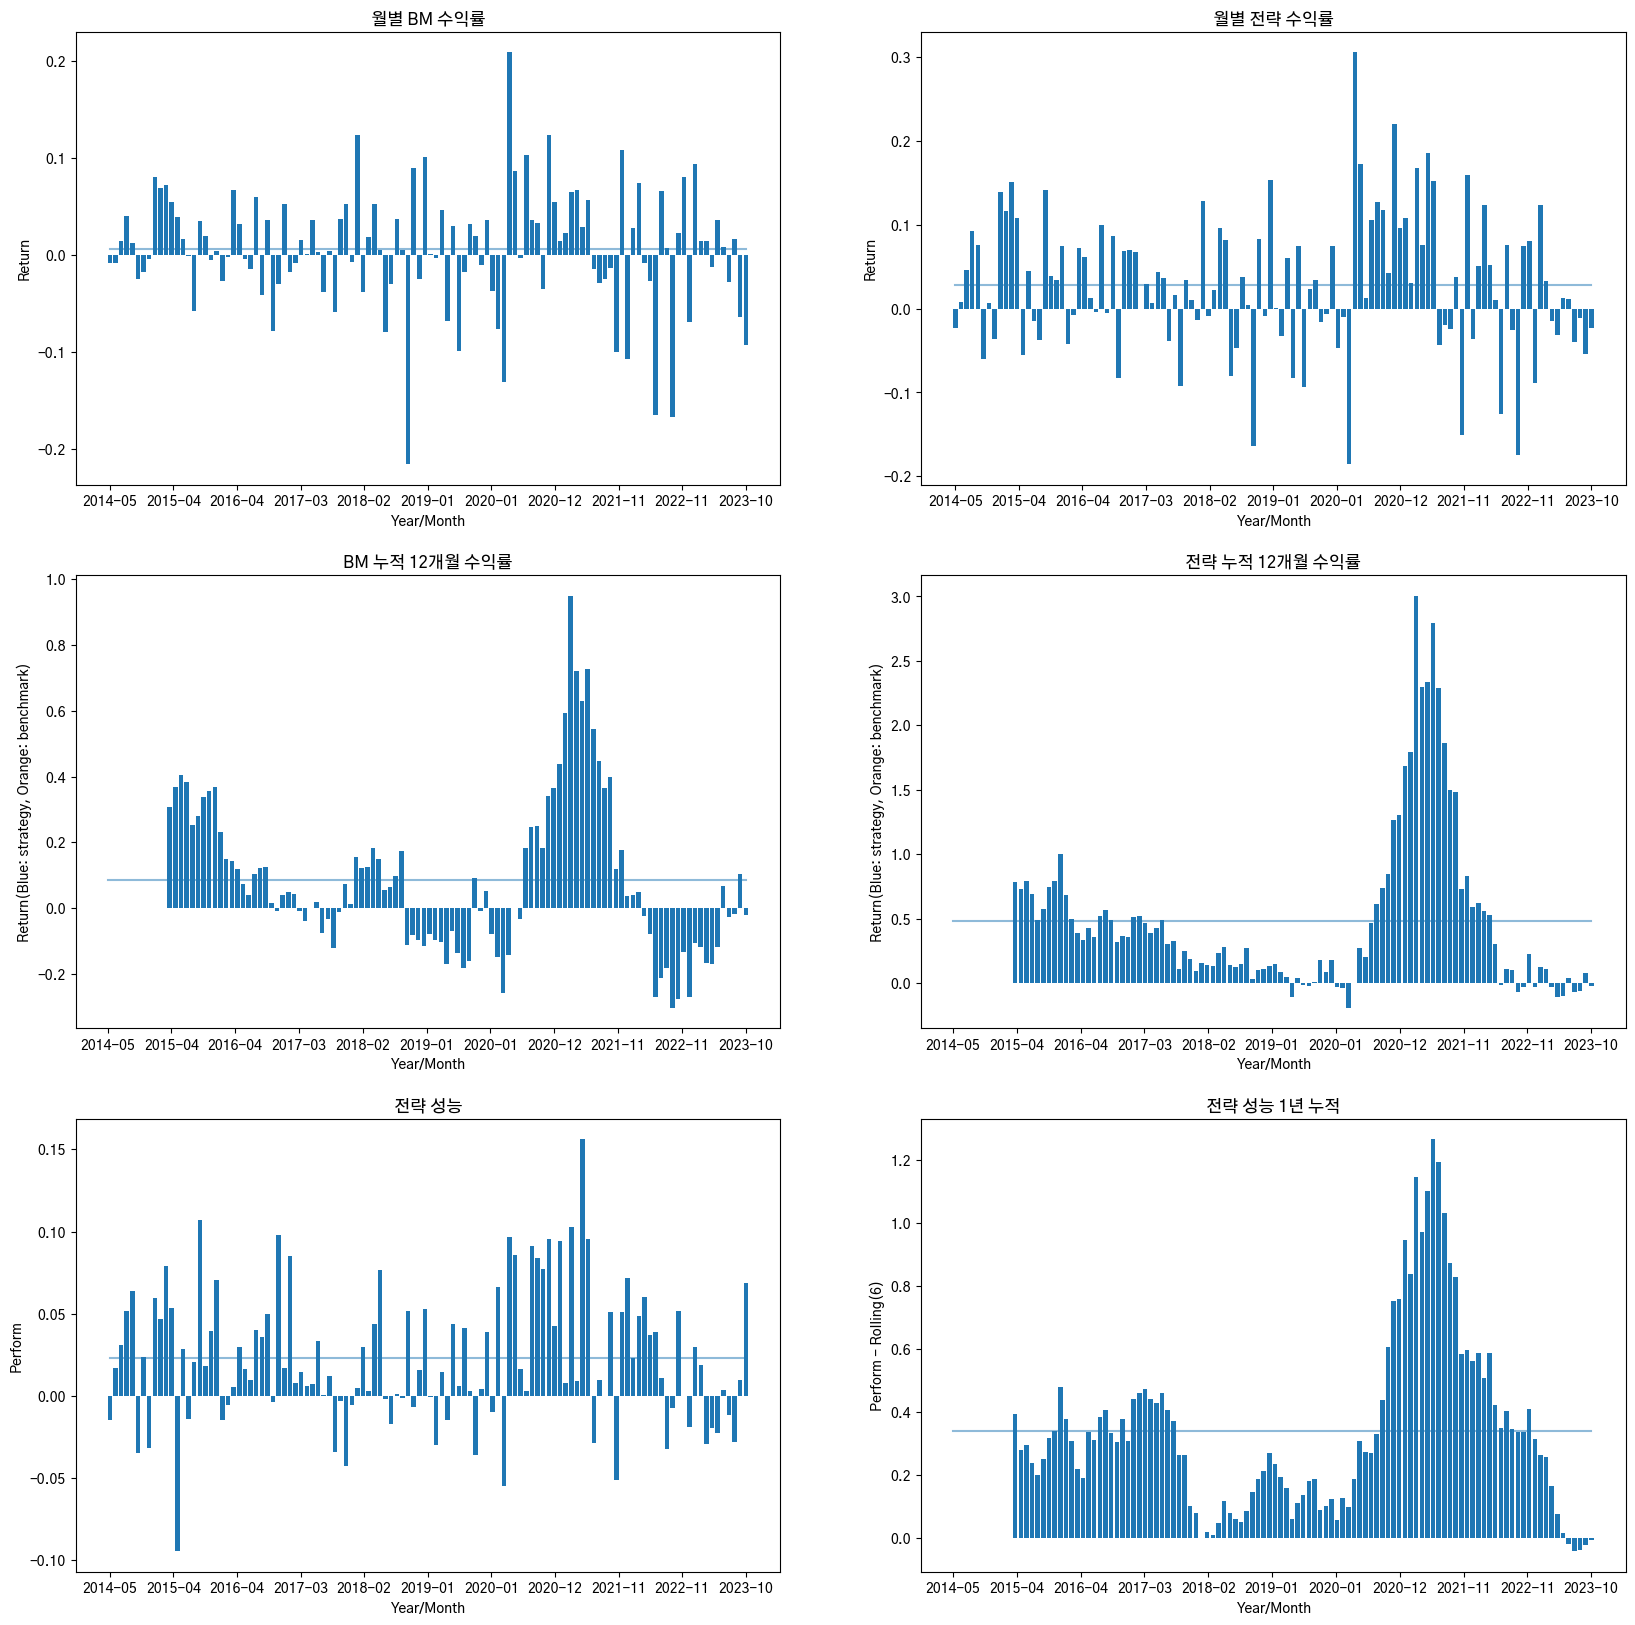

In [108]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 BM 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["BM 수익률"])
ax1.plot(months, [revisions["BM 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"BM 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["BM 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": (revisions["성능"] > 0).sum(),
    "under-perform": (revisions["성능"] < 0).sum(),
    "승률": (revisions["성능"] > 0).sum() / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})

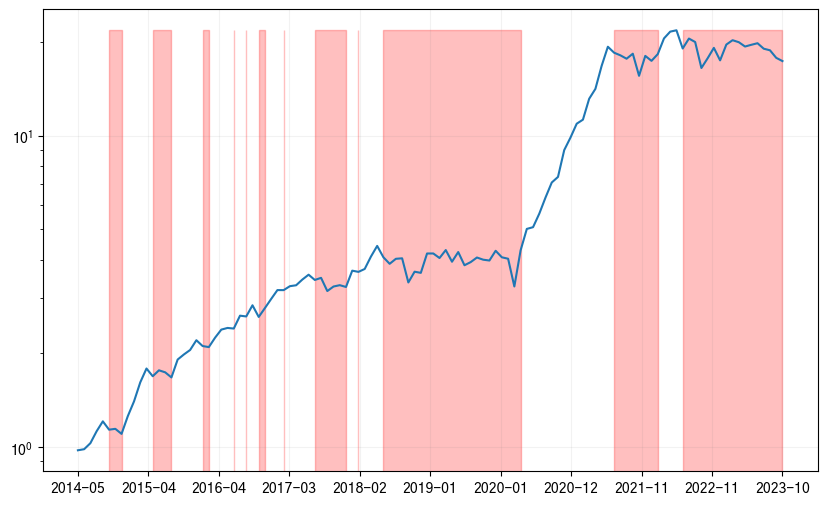

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 예시 생성
x_values = months
y_values = revisions["전략 누적수익률"]
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.yscale('log')
plt.xticks(np.quantile(np.arange(0, len(revisions)), xticks))
plt.grid(True)
plt.fill_between(
    x_values, y_values.max(),
    where=(revisions["전략 DD"] < 0),
    color="red", alpha=0.25
)